In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import pandas as pd
import random as rnd
import math, os, time, sys, re, datetime
from datetime import timedelta
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import stats

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#testset = 'A0202'
#INPUTS: python DLMHC.py 0 A0202
#testset = sys.argv[2] # e.g. takes A0202 as input allele name
testset = "A0101__"

print("Test set is ", testset)
runindx = 0 

###all the possible sequence letters
allSequences = 'ACEDGFIHKMLNQPSRTWVYZ'
# Establish a mapping from letters to integers
char2int = dict((c, i) for i, c in enumerate(allSequences))

Tensorflow version 2.7.0
Num GPUs Available:  1
Test set is  A0101__


2022-03-19 21:26:00.175585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 21:26:00.203371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 21:26:00.203470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def getdata_onehot(datafile):   #build testing matrix
    ### READ in test dataset
    """ Reads the test data file and extracts allele subtype,
            peptide length, and measurement type. Returns these information
            along with the peptide sequence and target values.
    """
    #train数据载入
    import os
    traindata = os.path.join("./../DATA", "train_data", datafile )
    print("traindata name: ", traindata)
    df_train = pd.read_csv(traindata, header=0)
    df_train = df_train[df_train.Peptide.str.contains('X') == False]
    df_train = df_train[df_train.Peptide.str.contains('B') == False]
    df_train = df_train[df_train.Peptide.str.contains('U') == False]
    #eg.df_train = pd.read_csv('./DATA/train_data/A0202',sep="\t")
    
    #下采样
    new_df_0 = df_train.loc[df_train['BindingCategory']== 0].sample(frac = 1)
    #上采样
    df_1_list = []
    for i in range(4):
        df_1_list.append(df_train.loc[df_train['BindingCategory']== 1])
        new_df_1 = pd.concat(df_1_list)
    new_df_train = pd.concat([new_df_0,new_df_1])
    new_df_train = new_df_train.sample(frac = 1.0) #shuffle


    #X_train--补齐11mer--one_hot_matrix
    train_data=transformEL(new_df_train)
    trainMatrix = np.empty((0, 11,len(allSequences)), int)      
    for num in range(len(train_data.Peptide)):
        if num%1000 == 0:
            print(train_data.Peptide.iloc[num],num)
        trainMatrix = np.append(trainMatrix, [Pept_OneHotMap(train_data.Peptide.iloc[num])], axis=0)
    allele_name = train_data['HLA'][0]
    assert (trainMatrix.shape[0] == train_data.shape[0])

    #test数据载入
    testdata = os.path.join("./../DATA", "test_data", datafile )
    df_test = pd.read_csv(testdata, header=0)
    df_test = df_test[df_test.Peptide.str.contains('X') == False]
    df_test = df_test[df_test.Peptide.str.contains('B') == False]
    df_test = df_test[df_test.Peptide.str.contains('U') == False]
    #eg.df_test = pd.read_csv('./DATA/test_data/A0202',sep="\t")

    #X_test--补齐11mer--one_hot_matrix
    test_data=transformEL(df_test)
    testMatrix = np.empty((0, 11,len(allSequences)), int)      
    for num in range(len(test_data.Peptide)):
        if num%1000 == 0:
            print(test_data.Peptide.iloc[num],num)
        testMatrix = np.append(testMatrix, [Pept_OneHotMap(test_data.Peptide.iloc[num])], axis=0)
    assert (testMatrix.shape[0] == test_data.shape[0])

    Y_train = train_data.BindingCategory
    Y_test = test_data.BindingCategory 
    #
    Y_train = Y_train.reset_index(drop=True)
    Y_test = Y_test.reset_index(drop=True)
    #
    trainlen = len(trainMatrix)
    ss1 = list(range(trainlen))
    rnd.shuffle(ss1)    #
    
    # combine training and test datasets
    datasets={}
    datasets['X_train'] = trainMatrix
    datasets['Y_train'] = Y_train.values #traindata.BindingCategory.as_matrix()
    datasets['X_test'] = testMatrix
    datasets['Y_test'] = Y_test.values    

    return datasets

def Pept_OneHotMap(peptideSeq):
    """ maps amino acid into its numerical index
    USAGE
    Pept_OneHotMap('A')
    array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    """
    # integer encode input data
    integer_encoded=[char2int[char] for char in peptideSeq]
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
    	letter = [0 for _ in range(len(allSequences))]
    	letter[value] = 1
    	onehot_encoded.append(letter)
    return np.asarray(onehot_encoded)

def transformEL(dataset):
    dataset = dataset.reset_index(drop=True)
    peptide=dataset.Peptide
    peptide2list=peptide.tolist()
    for i in range(len(peptide)):
        if len(peptide2list[i]) < 11:
            n1 = len(peptide2list[i]) // 2
            n2 = 11 - len(peptide2list[i])
            peptide2list[i] = peptide2list[i][:n1] + 'Z'*n2 + peptide2list[i][n1:]     #将小于11个氨基酸的peptide在中间插空补齐
        else:
            peptide2list[i] = peptide2list[i][:11]

    del dataset['Peptide']
    peptides = pd.DataFrame(peptide2list,columns=['Peptide'])
    dataset.insert(0,'Peptide',peptides.pop('Peptide'))
    return dataset

def binary2onehot(yy):
    yy2= np.zeros((len(yy),2), dtype=int) #yy2.shape #(10547, 2)
    for num in range(len(yy)):
        if yy[num]==1:
            yy2[num,0]=1
        else:
            yy2[num,1]=1
    return yy2

In [3]:
data=getdata_onehot(datafile=testset)

traindata name:  ./../DATA/train_data/A0101__
LLSTZZYLERY 0
ATTISSSSLYV 1000
EIDIZZLRTLY 2000
TTEIZZETLLL 0
QMVEILTEENR 1000


In [4]:
shuffle_ = np.arange(len(data['Y_train']))
np.random.shuffle(shuffle_)
data['Y_train']=data['Y_train'][shuffle_]
data['X_train']=data['X_train'][shuffle_]

print("X_Train size ", data['X_train'].shape)
print("Y_Train size ", data['Y_train'].shape)
print("Train data value=1 ", np.sum(data['Y_train']==1))
print("X_Test size " , data['X_test'].shape)
print("Y_Test size " , data['Y_test'].shape)
print("Test data value=1 ", np.sum(data['Y_test']==1))


Y_train_labels = binary2onehot(data['Y_train']) # binary output converted into two classes
Y_test_labels = binary2onehot(data['Y_test'])
X_train_data = data['X_train']  #already one hot encoded
X_test_data = data['X_test']

X_Train size  (3000, 11, 21)
Y_Train size  (3000,)
Train data value=1  2000
X_Test size  (2000, 11, 21)
Y_Test size  (2000,)
Test data value=1  300


In [26]:
# save proceed data to txt
print("X_Train size ", X_train_data.shape)
print("Y_Train size ", Y_train_labels.shape)
print("X_Test size " , X_test_data.shape)
print("Y_Test size " , Y_test_labels.shape, "\n")

X_train_data_reshape = X_train_data.reshape(X_train_data.shape[0], -1)
X_test_data_reshape = X_test_data.reshape(X_test_data.shape[0], -1)
np.savetxt("data_train.txt", X_train_data_reshape, fmt='%i')
np.savetxt("data_test.txt", X_test_data_reshape, fmt='%i')

np.savetxt("data_train_labels.txt", Y_train_labels, fmt='%i')
np.savetxt("data_test_labels.txt", Y_test_labels, fmt='%i')



X_Train size  (38630, 11, 21)
Y_Train size  (38630, 2)
X_Test size  (6199, 11, 21)
Y_Test size  (6199, 2) 



In [27]:
# from txt to numpy
X_train_data = np.loadtxt("data_train.txt")
X_train_data = X_train_data.reshape(X_train_data.shape[0], 11, 21)
X_test_data = np.loadtxt("data_test.txt")
X_test_data = X_test_data.reshape(X_test_data.shape[0], 11, 21)
Y_train_labels = np.loadtxt("data_train_labels.txt")
Y_test_labels = np.loadtxt("data_test_labels.txt")

print("X_Train size ", X_train_data.shape)
print("Y_Train size ", Y_train_labels.shape)
print("X_Test size " , X_test_data.shape)
print("Y_Test size " , Y_test_labels.shape)

print ("finish loading")

X_Train size  (38630, 11, 21)
Y_Train size  (38630, 2)
X_Test size  (6199, 11, 21)
Y_Test size  (6199, 2)
finish loading


In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# simple model
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(11, 21, 1)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

#import visualkeras
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

In [29]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(X_train_data, Y_train_labels, epochs=10, validation_split = 0.2)

Epoch 1/10
966/966 [==============================] - 3s 2ms/step - loss: 0.0691 - acc: 0.9786 - f1_m: 0.9601 - precision_m: 0.9893 - recall_m: 0.9348 - val_loss: 0.0404 - val_acc: 0.9900 - val_f1_m: 0.9797 - val_precision_m: 0.9954 - val_recall_m: 0.9650
Epoch 2/10
966/966 [==============================] - 2s 2ms/step - loss: 0.0402 - acc: 0.9891 - f1_m: 0.9760 - precision_m: 0.9961 - recall_m: 0.9573 - val_loss: 0.0391 - val_acc: 0.9894 - val_f1_m: 0.9750 - val_precision_m: 0.9965 - val_recall_m: 0.9550
Epoch 3/10
966/966 [==============================] - 2s 2ms/step - loss: 0.0310 - acc: 0.9916 - f1_m: 0.9791 - precision_m: 0.9969 - recall_m: 0.9625 - val_loss: 0.0381 - val_acc: 0.9887 - val_f1_m: 0.9715 - val_precision_m: 0.9973 - val_recall_m: 0.9478
Epoch 4/10
966/966 [==============================] - 2s 2ms/step - loss: 0.0200 - acc: 0.9936 - f1_m: 0.9828 - precision_m: 0.9978 - recall_m: 0.9686 - val_loss: 0.0294 - val_acc: 0.9922 - val_f1_m: 0.9826 - val_precision_m: 0.9962

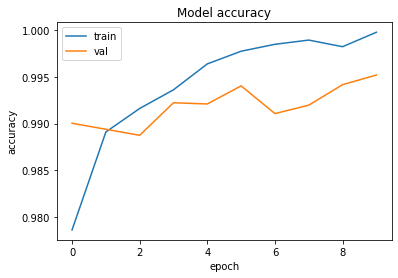

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
plt.savefig('acc_B4403.png', dpi=300)

In [32]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_data, Y_test_labels, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.05531679093837738 0.992418110370636 0.9875325560569763 0.9945122599601746 0.9809922575950623
